In [20]:

import numpy as np;
import matplotlib.pyplot as plt;
import pickle;
import plotly.graph_objects as go
import plotly.io as pio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


In [45]:
# Load the axis values
prefix = "data/v5_"
n = "3"

with open(prefix + "etheta_" + n + ".pkl", "rb") as file:
    etheta_data = pickle.load(file)

E_values = np.array(etheta_data['E'])  # Energy axis values (array of length 200)
theta_values = np.array(etheta_data['theta'])  # Theta axis values (array of length 10)

print("Loaded axis data:")
print(f"E axis has {len(E_values)} points ranging from {E_values[0]} to {E_values[-1]} MeV.")
print(f"Theta axis has {len(theta_values)} points ranging from {theta_values[0]} to {theta_values[-1]} degrees.")

print(theta_values)

# Load the cross-sectional data (images)
with open(prefix + "xsdata_" + n +".pkl", "rb") as file:
    xsdata_list = pickle.load(file)  # List of arrays, each array is shape (200, 10)

print(len(xsdata_list[0][0]))

num_samples = len(xsdata_list)
print(f"Loaded {len(xsdata_list)} images.")
print(f"Shape of the first image: {xsdata_list[0].shape}")


# Load the resonance information
with open(prefix + "info_" + n + ".pkl", "rb") as file:
    info_data = pickle.load(file)  # List of dictionaries, one per image

print(f"Loaded info for {len(info_data)} images.")
print(f"First image info keys: {info_data[0].keys()}")

Loaded axis data:
E axis has 200 points ranging from 0.1 to 6.0 MeV.
Theta axis has 30 points ranging from 0.6981317007977318 to 2.6179938779914944 degrees.
[0.6981317  0.76433384 0.83053599 0.89673813 0.96294028 1.02914242
 1.09534457 1.16154671 1.22774885 1.293951   1.36015314 1.42635529
 1.49255743 1.55875957 1.62496172 1.69116386 1.75736601 1.82356815
 1.88977029 1.95597244 2.02217458 2.08837673 2.15457887 2.22078101
 2.28698316 2.3531853  2.41938745 2.48558959 2.55179173 2.61799388]
30
Loaded 3 images.
Shape of the first image: (200, 30)
Loaded info for 3 images.
First image info keys: dict_keys(['n_res', 'res'])


[[ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 ...
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]]


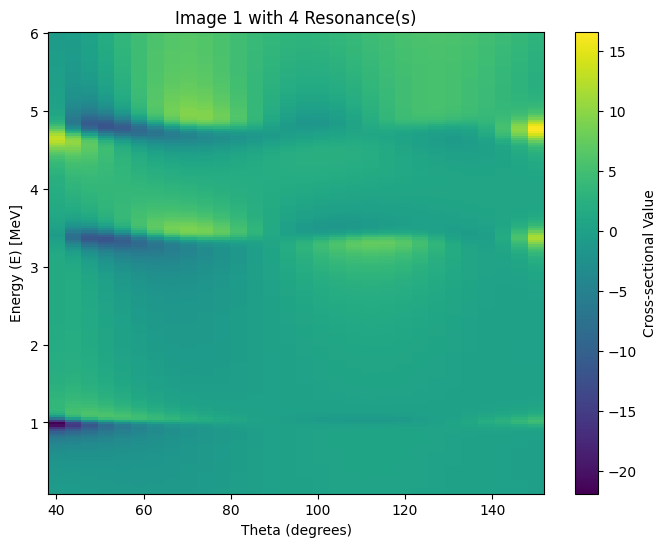

Image 1 Resonance Parameters:
  E_res: 4.7844 MeV, Gamma_res: 0.3096, l_res: 3
  E_res: 4.6555 MeV, Gamma_res: 0.3250, l_res: 0
  E_res: 1.0056 MeV, Gamma_res: 0.1374, l_res: 1
  E_res: 3.3788 MeV, Gamma_res: 0.2488, l_res: 3
[[ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 ...
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]]


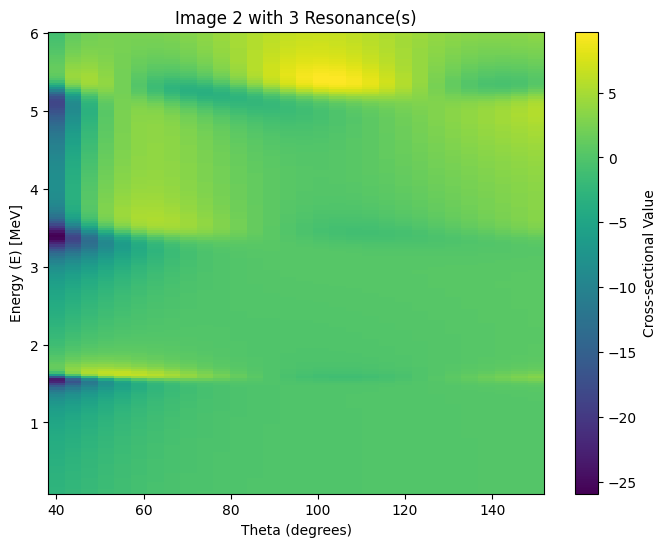

Image 2 Resonance Parameters:
  E_res: 5.2411 MeV, Gamma_res: 0.4049, l_res: 2
  E_res: 1.5743 MeV, Gamma_res: 0.1317, l_res: 1
  E_res: 3.3962 MeV, Gamma_res: 0.3761, l_res: 1
[[ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 ...
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]]


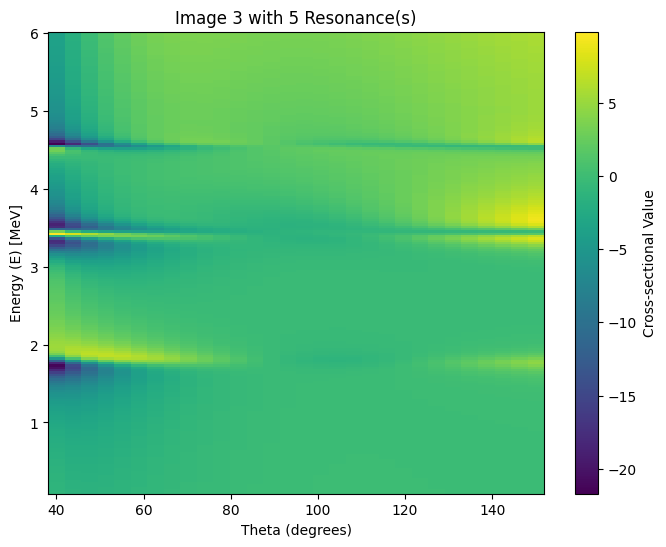

Image 3 Resonance Parameters:
  E_res: 1.7746 MeV, Gamma_res: 0.1938, l_res: 1
  E_res: 3.4115 MeV, Gamma_res: 0.3204, l_res: 1
  E_res: 4.5581 MeV, Gamma_res: 0.0721, l_res: 1
  E_res: 3.4304 MeV, Gamma_res: 0.1191, l_res: 1
  E_res: 3.5405 MeV, Gamma_res: 0.7409, l_res: 0


In [22]:
def plot_image(index):
    image_data = xsdata_list[index]  # Shape: (200, 10)
    
    # Convert theta_values from radians to degrees
    theta_values_deg = theta_values * (180.0 / np.pi)
    
    # Create a meshgrid with theta in degrees
    theta_grid_deg, E_grid = np.meshgrid(theta_values_deg, E_values)

    print(theta_grid_deg)
    
    plt.figure(figsize=(8, 6))
    # Plot using pcolormesh with theta in degrees on x-axis and energy on y-axis
    plt.pcolormesh(theta_grid_deg, E_grid, image_data, shading='auto', cmap='viridis')
    plt.colorbar(label='Cross-sectional Value')
    plt.xlabel('Theta (degrees)')
    plt.ylabel('Energy (E) [MeV]')
    plt.title(f'Image {index+1} with {info_data[index]["n_res"]} Resonance(s)')
    plt.show()
    
    # Print resonance parameters
    print(f"Image {index+1} Resonance Parameters:")
    for res in info_data[index]['res']:
        print(f"  E_res: {res['E_res']:.4f} MeV, Gamma_res: {res['Gamma_res']:.4f}, l_res: {res['l_res']}")



# Create a meshgrid from theta_values and E_values
theta_grid, E_grid = np.meshgrid(theta_values, E_values)


# Plot the first three images
for idx in range(3):
    plot_image(idx)


In [12]:
# Convert xsdata_list to a tensor
images = np.array(xsdata_list)  # Shape: (num_samples, 200, 10)
images = images[:, np.newaxis, :, :]  # Add channel dimension: (num_samples, 1, 200, 10)
images = torch.tensor(images, dtype=torch.float32)

print(images)
print(f"Images tensor shape: {images.shape}")  # Should be (num_samples, 1, 200, 10)


tensor([[[[-0.7993, -0.7935, -0.9048,  ..., -0.1242, -0.2141, -0.2896],
          [-0.8491, -0.8408, -0.9482,  ..., -0.1252, -0.2161, -0.2922],
          [-0.8975, -0.8882, -0.9917,  ..., -0.1262, -0.2181, -0.2952],
          ...,
          [-0.7559, -0.6284,  0.3396,  ...,  4.2891,  3.6699,  3.0371],
          [-0.7705, -0.6069,  0.3765,  ...,  4.3242,  3.7109,  3.0859],
          [-0.7964, -0.5869,  0.4187,  ...,  4.3633,  3.7578,  3.1406]]],


        [[[-2.7773, -2.3926, -1.9590,  ...,  0.1022,  0.1212,  0.1394],
          [-2.8164, -2.4258, -1.9863,  ...,  0.1026,  0.1218,  0.1400],
          [-2.8496, -2.4570, -2.0137,  ...,  0.1030,  0.1223,  0.1405],
          ...,
          [-0.8408,  1.2451,  2.1484,  ...,  2.9980,  3.1094,  3.3203],
          [-0.9653,  1.1270,  2.0723,  ...,  3.1094,  3.2285,  3.4375],
          [-1.0938,  1.0137,  2.0039,  ...,  3.2188,  3.3438,  3.5527]]],


        [[[-1.1416, -1.4707, -1.5283,  ..., -0.1797, -0.1825, -0.1847],
          [-1.1709, -1.500

In [23]:
# Parameters
max_objects = 10  # Maximum number of resonances per image

# Initialize target tensors
num_objects = torch.zeros(num_samples, dtype=torch.long)
energies = torch.zeros(num_samples, max_objects, dtype=torch.float32)
gammas = torch.zeros(num_samples, max_objects, dtype=torch.float32)
ls = torch.zeros(num_samples, max_objects, dtype=torch.long)
masks = torch.zeros(num_samples, max_objects, dtype=torch.float32)

for i in range(num_samples):
    n_res = info_data[i]['n_res']
    num_objects[i] = n_res
    masks[i, :n_res] = 1
    for j, res in enumerate(info_data[i]['res']):
        if j >= max_objects:
            break  # Ignore extra resonances beyond max_objects
        energies[i, j] = res['E_res']
        gammas[i, j] = res['Gamma_res']
        ls[i, j] = res['l_res']

targets = {
    'num_objects': num_objects,
    'energies': energies,
    'gammas': gammas,
    'ls': ls,
    'masks': masks,
}


In [24]:
# Compute the gradient of an image with Sobel operator.
def compute_image_gradient(image):
    """
    Computes the gradient of an image using the Sobel operator.

    Args:
        image (torch.Tensor): Input image tensor of shape (C, H, W).

    Returns:
        torch.Tensor: Gradient image tensor of shape (C, H, W).
    """
    # Define Sobel kernels
    sobel_kernel_x = torch.tensor([[1, 0, -1],
                                   [2, 0, -2],
                                   [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    sobel_kernel_y = torch.tensor([[1, 2, 1],
                                   [0, 0, 0],
                                   [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Move kernels to the same device as the image
    device = image.device
    sobel_kernel_x = sobel_kernel_x.to(device)
    sobel_kernel_y = sobel_kernel_y.to(device)

    # Pad the image to keep the same spatial dimensions
    image = image.unsqueeze(0)  # Add batch dimension
    padding = 1  # For 3x3 kernel
    image_padded = F.pad(image, (padding, padding, padding, padding), mode='reflect')

    # Convolve with Sobel kernels
    grad_x = F.conv2d(image_padded, sobel_kernel_x)
    grad_y = F.conv2d(image_padded, sobel_kernel_y)

    # Compute the gradient magnitude
    grad_magnitude = torch.sqrt(grad_x ** 2 + grad_y ** 2).squeeze(0)  # Remove batch dimension

    return grad_magnitude


In [7]:
class ResonanceDataset(Dataset):
    def __init__(self, data, targets, compute_gradients=False):
        self.data = data  # Shape: (num_samples, 1, H, W)
        self.targets = targets  # Dictionary with target parameters
        self.compute_gradients = compute_gradients

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]  # Shape: (1, H, W)
        target = {key: val[idx] for key, val in self.targets.items()}

        if self.compute_gradients:
            # Compute gradient for each channel
            channels = []
            for c in range(image.shape[0]):
                grad = compute_image_gradient(image[c])
                channels.append(grad)
            image = torch.stack(channels, dim=0)  # Shape: (C, H, W)

        return image, target


In [37]:
# Split the dataset
from torch.utils.data import random_split

dataset = ResonanceDataset(images, targets, compute_gradients=True)
print(len(dataset))

train_size = int(0.8 * len(dataset)) # 80-20 Training to validation split
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(len(train_dataset))
print(len(val_dataset))



3
2
1


Sample Index: 0
Number of Objects: 4
Energies: [4.784398  4.6555104 1.0056401 3.3788066]
Gammas: [0.30963773 0.32503948 0.13739899 0.24884735]
Angular Momenta (ls): [3 0 1 3]


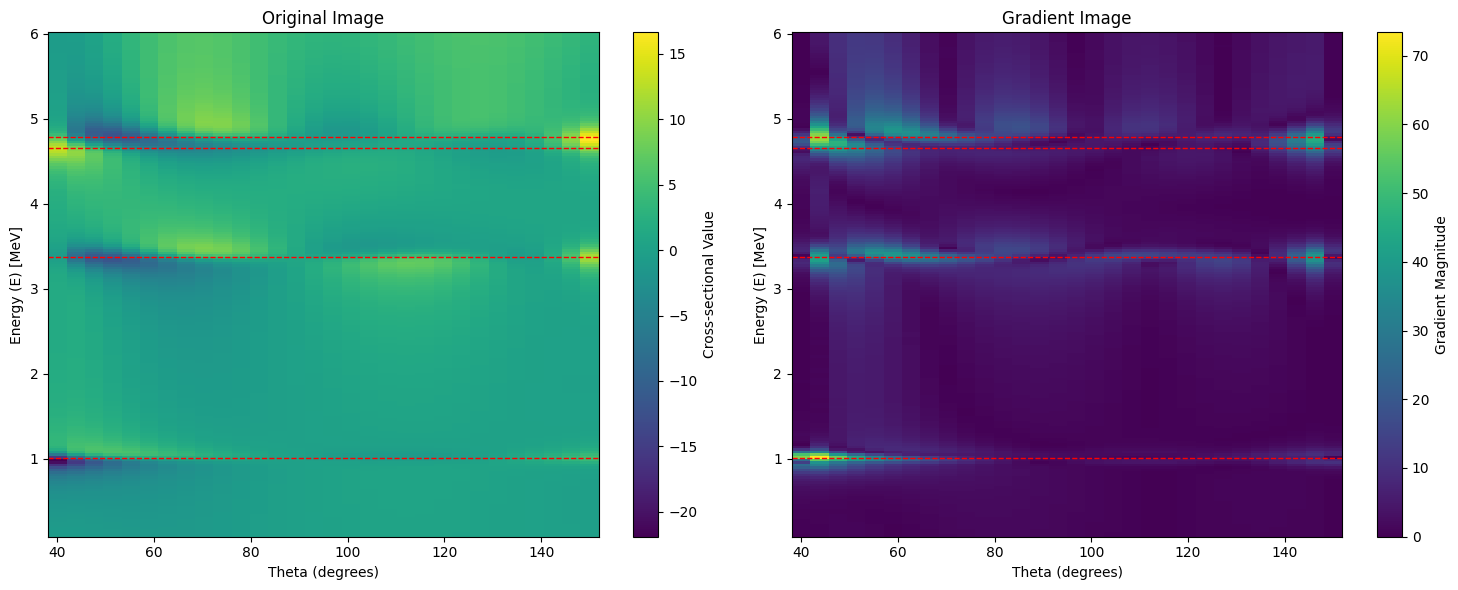

Sample Index: 1
Number of Objects: 3
Energies: [5.241131  1.5742751 3.3961718]
Gammas: [0.40486324 0.13168919 0.37612635]
Angular Momenta (ls): [2 1 1]


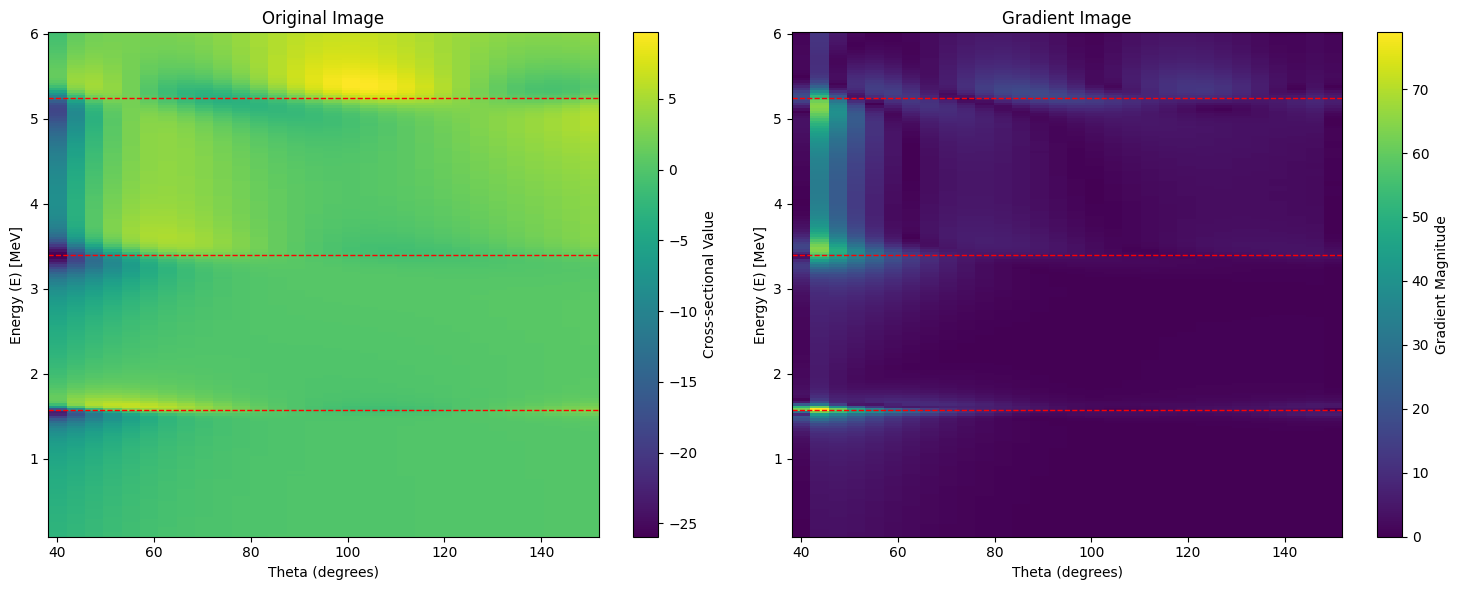

Sample Index: 2
Number of Objects: 5
Energies: [1.7745781 3.4115047 4.558118  3.430389  3.5405476]
Gammas: [0.19376816 0.32041553 0.0721246  0.1191161  0.74091035]
Angular Momenta (ls): [1 1 1 1 0]


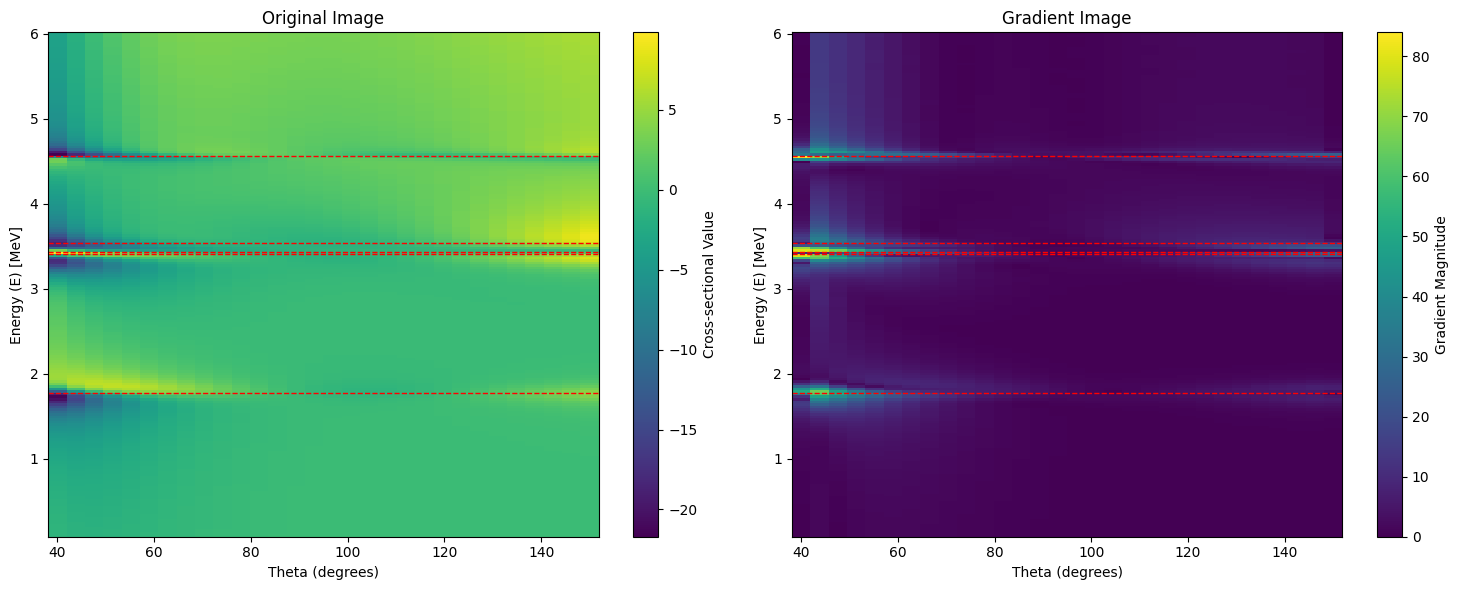

In [26]:
# Plot the original image against the sobel filter gradient version
def plot_image_gradient_comparision(index):
    # Convert theta axis to degrees
    theta_values_deg = theta_values * (180.0 / np.pi)
    theta_grid_deg, E_grid = np.meshgrid(theta_values_deg, E_values)

    # Get the gradient image and target from the dataset
    gradient_image, target = dataset[index]  # Returns (image, target)

    # Get the original image from the images array
    original_image = images[index]

    # Convert tensors to numpy arrays and squeeze to remove singleton dimensions
    if isinstance(original_image, torch.Tensor):
        original_image_np = original_image.squeeze().numpy()
    else:
        original_image_np = original_image.squeeze()

    if isinstance(gradient_image, torch.Tensor):
        gradient_image_np = gradient_image.squeeze().numpy()
    else:
        gradient_image_np = gradient_image.squeeze()

    # Retrieve target parameters
    num_objects = target['num_objects'].item()
    energies = target['energies'][:num_objects].numpy()
    gammas = target['gammas'][:num_objects].numpy()
    ls = target['ls'][:num_objects].numpy()

    # Print out the target parameters
    print(f"Sample Index: {index}")
    print(f"Number of Objects: {num_objects}")
    print(f"Energies: {energies}")
    print(f"Gammas: {gammas}")
    print(f"Angular Momenta (ls): {ls}")

    # Plot the images with correct axes
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Original Image
    ax1 = axes[0]
    im1 = ax1.pcolormesh(theta_grid_deg, E_grid, original_image_np, shading='auto', cmap='viridis')
    ax1.set_title('Original Image')
    ax1.set_xlabel('Theta (degrees)')
    ax1.set_ylabel('Energy (E) [MeV]')
    fig.colorbar(im1, ax=ax1, label='Cross-sectional Value')

    # Overlay the resonance energies on the original image
    for energy in energies:
        ax1.axhline(y=energy, color='red', linestyle='--', linewidth=1)

    # Gradient Image
    ax2 = axes[1]
    im2 = ax2.pcolormesh(theta_grid_deg, E_grid, gradient_image_np, shading='auto', cmap='viridis')
    ax2.set_title('Gradient Image')
    ax2.set_xlabel('Theta (degrees)')
    ax2.set_ylabel('Energy (E) [MeV]')
    fig.colorbar(im2, ax=ax2, label='Gradient Magnitude')

    # Overlay the resonance energies on the gradient image
    for energy in energies:
        ax2.axhline(y=energy, color='red', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()

for i in range(3):
    plot_image_gradient_comparision(i)


In [38]:
class ResonanceDetectionModel(nn.Module):
    def __init__(self, max_objects=10, num_l_classes=5):
        super(ResonanceDetectionModel, self).__init__()
        self.max_objects = max_objects
        self.num_l_classes = num_l_classes

        # Convolutional layers with batch normalization and pooling
        self.conv1 = nn.Conv2d(1, 80, kernel_size=2, padding='same')
        self.bn1 = nn.BatchNorm2d(80)
        self.conv2 = nn.Conv2d(80, 160, kernel_size=2, padding='same')
        self.bn2 = nn.BatchNorm2d(160)
        self.conv3 = nn.Conv2d(160, 320, kernel_size=2, padding='same')
        self.bn3 = nn.BatchNorm2d(320)
        self.conv4 = nn.Conv2d(320, 640, kernel_size=2, padding='same')
        self.bn4 = nn.BatchNorm2d(640)
        self.pool = nn.MaxPool2d(kernel_size=(2, 1), stride=(2,1))
        
        # Calculate the flattened size after convolutions
        self.flattened_size = self.calculate_flattened_size()
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.3)
        
        # Output layers
        self.num_objects = nn.Linear(128, 1)  # Scalar output for number of objects
        # For each object: confidence, E_res, Gamma_res, and l (as classification)
        self.object_params = nn.Linear(128, max_objects * (1 + 2 + num_l_classes))  # Outputs per-object parameters

    def calculate_flattened_size(self):
        # Create a dummy input to pass through the conv layers and get the output size
        # Adjust the dimensions as per your input data (e.g., (1, 1, 200, 10))
        dummy_input = torch.zeros(1, 1, 200, 30)
        x = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        flattened_size = x.view(1, -1).size(1)
        return flattened_size

    def forward(self, x):
        batch_size = x.size(0)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = x.view(batch_size, -1)  # Flatten the tensor
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        # Predict the number of objects (regressed to a float between 0 and max_objects)
        num_objects = torch.sigmoid(self.num_objects(x)) * self.max_objects
        
        # Predict per-object parameters
        object_params = self.object_params(x).view(batch_size, self.max_objects, -1)
        
        # Split the object_params into individual components
        confidences = torch.sigmoid(object_params[:, :, 0])  # Confidence scores between 0 and 1
        energies = object_params[:, :, 1]  # Energy values
        gammas = torch.exp(object_params[:, :, 2])  # Gamma values (use F.softplus for positive values)
        l_logits = object_params[:, :, 3:]  # Logits for l classes
        
        outputs = {
            'num_objects': num_objects.squeeze(1),  # Shape: (batch_size,)
            'confidences': confidences,             # Shape: (batch_size, max_objects)
            'energies': energies,                   # Shape: (batch_size, max_objects)
            'gammas': gammas,                       # Shape: (batch_size, max_objects)
            'l_logits': l_logits                    # Shape: (batch_size, max_objects, num_l_classes)
        }
        return outputs


In [39]:
def loss_function(outputs, targets):
    # Loss on the number of objects detected
    loss_num_objects = F.mse_loss(outputs['num_objects'], targets['num_objects'].float())

    # Masks to indicate valid objects
    masks = targets['masks']  # Shape: (batch_size, max_objects)

    # Loss on confidences (Binary Cross-Entropy)
    loss_confidences = F.binary_cross_entropy(outputs['confidences'], masks.float())

    # Loss on energies and gammas (only for valid objects)
    energies_loss = F.mse_loss(outputs['energies'] * masks, targets['energies'] * masks)
    gammas_loss = F.mse_loss(outputs['gammas'] * masks, targets['gammas'] * masks)

    # Loss on l (angular momentum classes)
    l_logits = outputs['l_logits']  # Shape: (batch_size, max_objects, num_l_classes)
    l_targets = targets['ls'].long()  # Shape: (batch_size, max_objects)
    # Flatten tensors and apply mask
    l_logits = l_logits.view(-1, outputs['l_logits'].size(-1))  # (batch_size * max_objects, num_l_classes)
    l_targets = l_targets.view(-1)  # (batch_size * max_objects)
    masks_flat = masks.view(-1)
    # Select valid entries
    l_logits = l_logits[masks_flat == 1]
    l_targets = l_targets[masks_flat == 1]
    loss_l = F.cross_entropy(l_logits, l_targets)

    # Total loss
    total_loss = loss_num_objects + loss_confidences + energies_loss + gammas_loss + loss_l

    # Return all loss components
    loss_dict = {
        'total_loss': total_loss,
        'loss_num_objects': loss_num_objects,
        'loss_confidences': loss_confidences,
        'energies_loss': energies_loss,
        'gammas_loss': gammas_loss,
        'ls_loss': loss_l
    }

    return loss_dict


In [40]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [41]:
# Initialize the model, optimizer, and loss function
model = ResonanceDetectionModel(max_objects=max_objects)
model.to(device)  # Move the model to the device
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)


In [34]:
# Training and validation loop
num_epochs = 100  # Number of epochs
best_val_loss = float('inf')  # Initialize best validation loss for checkpointing

# Initialize lists to store training and validation losses and metrics before the training loop
train_losses = []
val_losses = []
train_r2_scores_history = {'num_objects': [], 'energies': [], 'gammas': []}
val_r2_scores_history = {'num_objects': [], 'energies': [], 'gammas': []}
train_l_accuracy_history = []
val_l_accuracy_history = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss_dict = {
        'total_loss': 0.0,
        'loss_num_objects': 0.0,
        'loss_confidences': 0.0,
        'energies_loss': 0.0,
        'gammas_loss': 0.0,
        'ls_loss': 0.0
    }
    # Initialize lists to store predictions and targets for R² computation
    train_outputs_accum = {
        'num_objects': [],
        'energies': [],
        'gammas': [],
        'ls': []
    }
    train_targets_accum = {
        'num_objects': [],
        'energies': [],
        'gammas': [],
        'ls': []
    }
    
    for batch_images, batch_targets in train_loader:
        
        # Move data and targets to the device
        batch_images = batch_images.to(device)
        batch_targets = {key: val.to(device) for key, val in batch_targets.items()}
        
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss_dict = loss_function(outputs, batch_targets)
        loss = loss_dict['total_loss']
        loss.backward()
        optimizer.step()
        
        # Accumulate losses
        for key in train_loss_dict:
            train_loss_dict[key] += loss_dict[key].item()
        
        # Accumulate predictions and targets for R² computation
        train_outputs_accum['num_objects'].append(outputs['num_objects'].detach().cpu())
        train_targets_accum['num_objects'].append(batch_targets['num_objects'].detach().cpu())
        
        # For per-object parameters, we need to consider only valid objects
        masks = batch_targets['masks'].detach().cpu()
        valid_indices = masks.view(-1).bool() # Remove zero entries (from padding)
        
        for param in ['energies', 'gammas']:
            # Apply masks to outputs and targets
            outputs_param = (outputs[param].detach().cpu() * masks).view(-1)
            targets_param = (batch_targets[param].detach().cpu() * masks).view(-1)
            train_outputs_accum[param].append(outputs_param[valid_indices])
            train_targets_accum[param].append(targets_param[valid_indices])

        # For l (classification)
        l_logits = outputs['l_logits'].detach().cpu()
        l_preds = torch.argmax(l_logits, dim=-1)
        l_preds = l_preds.view(-1)[valid_indices]
        l_targets = batch_targets['ls'].detach().cpu().view(-1)[valid_indices]
        train_outputs_accum['ls'].append(l_preds)
        train_targets_accum['ls'].append(l_targets)
            
    # Compute average losses
    for key in train_loss_dict:
        train_loss_dict[key] /= len(train_loader)
    
    # For regression outputs
    train_r2_scores = {}
    for key in ['num_objects', 'energies', 'gammas']:
        train_outputs_concat = torch.cat(train_outputs_accum[key], dim=0).numpy()
        train_targets_concat = torch.cat(train_targets_accum[key], dim=0).numpy()
        train_r2_scores[key] = r2_score(train_targets_concat, train_outputs_concat)

    # For l (classification)
    train_l_preds = torch.cat(train_outputs_accum['ls'], dim=0).numpy()
    train_l_targets = torch.cat(train_targets_accum['ls'], dim=0).numpy()
    train_l_accuracy = accuracy_score(train_l_targets, train_l_preds)

    # Append losses and metrics to the lists for plotting later
    train_losses.append(train_loss_dict['total_loss'])
    for key in ['num_objects', 'energies', 'gammas']:
        train_r2_scores_history[key].append(train_r2_scores[key])
    train_l_accuracy_history.append(train_l_accuracy)

        
    # Validation phase
    model.eval()
    val_loss_dict = {
        'total_loss': 0.0,
        'loss_num_objects': 0.0,
        'loss_confidences': 0.0,
        'energies_loss': 0.0,
        'gammas_loss': 0.0,
        'ls_loss': 0.0
    }
    val_outputs_accum = {
        'num_objects': [],
        'energies': [],
        'gammas': [],
        'ls': []
    }
    val_targets_accum = {
        'num_objects': [],
        'energies': [],
        'gammas': [],
        'ls': []
    }
    with torch.no_grad():
        for batch_images, batch_targets in val_loader:
            # Move data and targets to the device
            batch_images = batch_images.to(device)
            batch_targets = {key: val.to(device) for key, val in batch_targets.items()}
            
            outputs = model(batch_images)
            loss_dict = loss_function(outputs, batch_targets)
            
            # Accumulate losses
            for key in val_loss_dict:
                val_loss_dict[key] += loss_dict[key].item()
            
            # Accumulate predictions and targets for R² computation
            val_outputs_accum['num_objects'].append(outputs['num_objects'].detach().cpu())
            val_targets_accum['num_objects'].append(batch_targets['num_objects'].detach().cpu())
            
            masks = batch_targets['masks'].detach().cpu()
            valid_indices = masks.view(-1).bool()
            for param in ['energies', 'gammas']:
                outputs_param = (outputs[param].detach().cpu() * masks).view(-1)
                targets_param = (batch_targets[param].detach().cpu() * masks).view(-1)
                val_outputs_accum[param].append(outputs_param[valid_indices])
                val_targets_accum[param].append(targets_param[valid_indices])
                
            # For l (classification)
            l_logits = outputs['l_logits'].detach().cpu()
            l_preds = torch.argmax(l_logits, dim=-1)
            l_preds = l_preds.view(-1)[valid_indices]
            l_targets = batch_targets['ls'].detach().cpu().view(-1)[valid_indices]
            val_outputs_accum['ls'].append(l_preds)
            val_targets_accum['ls'].append(l_targets)

    
    # Compute average losses
    for key in val_loss_dict:
        val_loss_dict[key] /= len(val_loader)
    
    # Concatenate all accumulated outputs and targets
    # For regression outputs
    val_r2_scores = {}
    for key in ['num_objects', 'energies', 'gammas']:
        val_outputs_concat = torch.cat(val_outputs_accum[key], dim=0).numpy()
        val_targets_concat = torch.cat(val_targets_accum[key], dim=0).numpy()
        val_r2_scores[key] = r2_score(val_targets_concat, val_outputs_concat)

    # For l (classification)
    val_l_preds = torch.cat(val_outputs_accum['ls'], dim=0).numpy()
    val_l_targets = torch.cat(val_targets_accum['ls'], dim=0).numpy()
    val_l_accuracy = accuracy_score(val_l_targets, val_l_preds)

    # Append losses and metrics to the lists for plotting later
    val_losses.append(val_loss_dict['total_loss'])
    for key in ['num_objects', 'energies', 'gammas']:
        val_r2_scores_history[key].append(val_r2_scores[key])
    val_l_accuracy_history.append(val_l_accuracy)
    
    # Save the model checkpoint if validation loss improved
    if val_loss_dict['total_loss'] < best_val_loss:
        best_val_loss = val_loss_dict['total_loss']
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Print Training Metrics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Training Losses:")
    print(f"    Total Loss: {train_loss_dict['total_loss']:.4f}")
    print(f"    Num Objects Loss: {train_loss_dict['loss_num_objects']:.4f}")
    print(f"    Confidences Loss: {train_loss_dict['loss_confidences']:.4f}")
    print(f"    Energies Loss: {train_loss_dict['energies_loss']:.4f}")
    print(f"    Gammas Loss: {train_loss_dict['gammas_loss']:.4f}")
    print(f"    ls Loss: {train_loss_dict['ls_loss']:.4f}")
    print(f"  Training Metrics:")
    print(f"    Num Objects R²: {train_r2_scores['num_objects']:.4f}")
    print(f"    Energies R²: {train_r2_scores['energies']:.4f}")
    print(f"    Gammas R²: {train_r2_scores['gammas']:.4f}")
    print(f"    ls Accuracy: {train_l_accuracy:.4f}")

    # Print Validation Metrics
    print(f"  Validation Losses:")
    print(f"    Total Loss: {val_loss_dict['total_loss']:.4f}")
    print(f"    Num Objects Loss: {val_loss_dict['loss_num_objects']:.4f}")
    print(f"    Confidences Loss: {val_loss_dict['loss_confidences']:.4f}")
    print(f"    Energies Loss: {val_loss_dict['energies_loss']:.4f}")
    print(f"    Gammas Loss: {val_loss_dict['gammas_loss']:.4f}")
    print(f"    ls Loss: {val_loss_dict['ls_loss']:.4f}")
    print(f"  Validation Metrics:")
    print(f"    Num Objects R²: {val_r2_scores['num_objects']:.4f}")
    print(f"    Energies R²: {val_r2_scores['energies']:.4f}")
    print(f"    Gammas R²: {val_r2_scores['gammas']:.4f}")
    print(f"    ls Accuracy: {val_l_accuracy:.4f}")



{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'ls': tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [3, 0, 1, 3, 0, 0, 0, 0, 0, 0]]), 'masks': tensor([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]])}


/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 1/100
  Training Losses:
    Total Loss: 9.0542
    Num Objects Loss: 0.6234
    Confidences Loss: 0.6805
    Energies Loss: 5.8107
    Gammas Loss: 0.2570
    ls Loss: 1.6826
  Training Metrics:
    Num Objects R²: -1.4937
    Energies R²: -7.7841
    Gammas R²: -15.3406
    ls Accuracy: 0.1111
  Validation Losses:
    Total Loss: 7.5096
    Num Objects Loss: 1.0618
    Confidences Loss: 0.6978
    Energies Loss: 4.0040
    Gammas Loss: 0.1349
    ls Loss: 1.6111
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -4.9557
    Gammas R²: -28.9228
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 2/100
  Training Losses:
    Total Loss: 19.4073
    Num Objects Loss: 11.5509
    Confidences Loss: 0.6952
    Energies Loss: 4.2469
    Gammas Loss: 0.4831
    ls Loss: 2.4312
  Training Metrics:
    Num Objects R²: -45.2035
    Energies R²: -5.4202
    Gammas R²: -29.7199
    ls Accuracy: 0.0000
  Validation Losses:
    Total Loss: 8.6777
    Num Objects Loss: 2.5199
    Confidences Loss: 0.6761
    Energies Loss: 3.7250
    Gammas Loss: 0.1312
    ls Loss: 1.6255
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -4.5407
    Gammas R²: -28.1197
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 3/100
  Training Losses:
    Total Loss: 8.6302
    Num Objects Loss: 2.4560
    Confidences Loss: 0.6867
    Energies Loss: 2.5752
    Gammas Loss: 0.2404
    ls Loss: 2.6720
  Training Metrics:
    Num Objects R²: -8.8239
    Energies R²: -2.8929
    Gammas R²: -14.2848
    ls Accuracy: 0.0000
  Validation Losses:
    Total Loss: 11.6231
    Num Objects Loss: 5.5855
    Confidences Loss: 0.6737
    Energies Loss: 3.5396
    Gammas Loss: 0.1444
    ls Loss: 1.6798
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -4.2650
    Gammas R²: -31.0523
    ls Accuracy: 0.0000
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 4/100
  Training Losses:
    Total Loss: 22.3990
    Num Objects Loss: 11.0981
    Confidences Loss: 0.8751
    Energies Loss: 1.6893
    Gammas Loss: 5.8698
    ls Loss: 2.8667
  Training Metrics:
    Num Objects R²: -43.3923
    Energies R²: -1.5538
    Gammas R²: -372.2674
    ls Accuracy: 0.1111
  Validation Losses:
    Total Loss: 11.2661
    Num Objects Loss: 5.4356
    Confidences Loss: 0.6987
    Energies Loss: 3.3399
    Gammas Loss: 0.1230
    ls Loss: 1.6689
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -3.9678
    Gammas R²: -26.2952
    ls Accuracy: 0.0000
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409,

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 5/100
  Training Losses:
    Total Loss: 13.2790
    Num Objects Loss: 7.0793
    Confidences Loss: 0.9706
    Energies Loss: 2.0366
    Gammas Loss: 0.4680
    ls Loss: 2.7245
  Training Metrics:
    Num Objects R²: -27.3173
    Energies R²: -2.0788
    Gammas R²: -28.7634
    ls Accuracy: 0.1111
  Validation Losses:
    Total Loss: 9.2328
    Num Objects Loss: 3.5652
    Confidences Loss: 0.7109
    Energies Loss: 3.2516
    Gammas Loss: 0.0979
    ls Loss: 1.6072
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -3.8365
    Gammas R²: -20.7158
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 6/100
  Training Losses:
    Total Loss: 15.6316
    Num Objects Loss: 8.4409
    Confidences Loss: 1.0621
    Energies Loss: 1.8732
    Gammas Loss: 0.5532
    ls Loss: 3.7022
  Training Metrics:
    Num Objects R²: -32.7636
    Energies R²: -1.8317
    Gammas R²: -34.1781
    ls Accuracy: 0.0000
  Validation Losses:
    Total Loss: 7.2710
    Num Objects Loss: 1.7389
    Confidences Loss: 0.7149
    Energies Loss: 3.1884
    Gammas Loss: 0.0752
    ls Loss: 1.5536
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -3.7426
    Gammas R²: -15.6813
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 7/100
  Training Losses:
    Total Loss: 9.6710
    Num Objects Loss: 2.8714
    Confidences Loss: 1.2360
    Energies Loss: 1.4618
    Gammas Loss: 1.1433
    ls Loss: 2.9585
  Training Metrics:
    Num Objects R²: -10.4857
    Energies R²: -1.2099
    Gammas R²: -71.7053
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 6.3411
    Num Objects Loss: 0.9330
    Confidences Loss: 0.7201
    Energies Loss: 3.1092
    Gammas Loss: 0.0595
    ls Loss: 1.5194
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -3.6247
    Gammas R²: -12.1968
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 8/100
  Training Losses:
    Total Loss: 13.7025
    Num Objects Loss: 8.2110
    Confidences Loss: 1.0829
    Energies Loss: 1.1492
    Gammas Loss: 0.0419
    ls Loss: 3.2174
  Training Metrics:
    Num Objects R²: -31.8441
    Energies R²: -0.7373
    Gammas R²: -1.6616
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 6.1247
    Num Objects Loss: 0.7922
    Confidences Loss: 0.7332
    Energies Loss: 3.0316
    Gammas Loss: 0.0537
    ls Loss: 1.5140
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -3.5093
    Gammas R²: -10.9113
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 9/100
  Training Losses:
    Total Loss: 20.9385
    Num Objects Loss: 14.5506
    Confidences Loss: 0.7628
    Energies Loss: 1.6962
    Gammas Loss: 0.0537
    ls Loss: 3.8751
  Training Metrics:
    Num Objects R²: -57.2023
    Energies R²: -1.5641
    Gammas R²: -2.4180
    ls Accuracy: 0.1111
  Validation Losses:
    Total Loss: 6.3283
    Num Objects Loss: 1.0617
    Confidences Loss: 0.7587
    Energies Loss: 2.9376
    Gammas Loss: 0.0551
    ls Loss: 1.5151
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -3.3695
    Gammas R²: -11.2305
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 10/100
  Training Losses:
    Total Loss: 13.1936
    Num Objects Loss: 7.1860
    Confidences Loss: 1.1020
    Energies Loss: 2.2021
    Gammas Loss: 0.0449
    ls Loss: 2.6586
  Training Metrics:
    Num Objects R²: -27.7441
    Energies R²: -2.3289
    Gammas R²: -1.8576
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 6.9189
    Num Objects Loss: 1.6791
    Confidences Loss: 0.7872
    Energies Loss: 2.8504
    Gammas Loss: 0.0533
    ls Loss: 1.5489
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -3.2397
    Gammas R²: -10.8282
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 11/100
  Training Losses:
    Total Loss: 20.6528
    Num Objects Loss: 13.9247
    Confidences Loss: 1.7570
    Energies Loss: 0.9588
    Gammas Loss: 0.0480
    ls Loss: 3.9643
  Training Metrics:
    Num Objects R²: -54.6989
    Energies R²: -0.4494
    Gammas R²: -2.0512
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 8.3523
    Num Objects Loss: 3.1499
    Confidences Loss: 0.8042
    Energies Loss: 2.7604
    Gammas Loss: 0.0514
    ls Loss: 1.5864
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -3.1059
    Gammas R²: -10.3976
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 12/100
  Training Losses:
    Total Loss: 9.9852
    Num Objects Loss: 4.7336
    Confidences Loss: 1.5157
    Energies Loss: 0.3399
    Gammas Loss: 0.0890
    ls Loss: 3.3070
  Training Metrics:
    Num Objects R²: -17.9343
    Energies R²: 0.4862
    Gammas R²: -4.6580
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 10.3597
    Num Objects Loss: 5.1324
    Confidences Loss: 0.8243
    Energies Loss: 2.6996
    Gammas Loss: 0.0532
    ls Loss: 1.6502
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -3.0154
    Gammas R²: -10.8093
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 13/100
  Training Losses:
    Total Loss: 23.1970
    Num Objects Loss: 14.4619
    Confidences Loss: 1.0360
    Energies Loss: 3.1819
    Gammas Loss: 1.2109
    ls Loss: 3.3063
  Training Metrics:
    Num Objects R²: -56.8476
    Energies R²: -3.8102
    Gammas R²: -76.0037
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 12.9245
    Num Objects Loss: 7.6190
    Confidences Loss: 0.8461
    Energies Loss: 2.6634
    Gammas Loss: 0.0544
    ls Loss: 1.7417
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -2.9616
    Gammas R²: -11.0786
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000,

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 14/100
  Training Losses:
    Total Loss: 9.2377
    Num Objects Loss: 1.8524
    Confidences Loss: 1.8380
    Energies Loss: 2.0090
    Gammas Loss: 0.0621
    ls Loss: 3.4762
  Training Metrics:
    Num Objects R²: -6.4096
    Energies R²: -2.0371
    Gammas R²: -2.9474
    ls Accuracy: 0.3333
  Validation Losses:
    Total Loss: 12.5468
    Num Objects Loss: 7.1952
    Confidences Loss: 0.8553
    Energies Loss: 2.6337
    Gammas Loss: 0.0498
    ls Loss: 1.8127
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -2.9175
    Gammas R²: -10.0485
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 15/100
  Training Losses:
    Total Loss: 12.0134
    Num Objects Loss: 6.7413
    Confidences Loss: 0.6249
    Energies Loss: 1.0497
    Gammas Loss: 0.5420
    ls Loss: 3.0556
  Training Metrics:
    Num Objects R²: -25.9654
    Energies R²: -0.5868
    Gammas R²: -33.4648
    ls Accuracy: 0.1111
  Validation Losses:
    Total Loss: 11.1841
    Num Objects Loss: 5.7952
    Confidences Loss: 0.8561
    Energies Loss: 2.6073
    Gammas Loss: 0.0471
    ls Loss: 1.8785
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -2.8782
    Gammas R²: -9.4501
    ls Accuracy: 0.0000
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 16/100
  Training Losses:
    Total Loss: 12.3606
    Num Objects Loss: 4.4979
    Confidences Loss: 1.1661
    Energies Loss: 1.9344
    Gammas Loss: 1.7408
    ls Loss: 3.0214
  Training Metrics:
    Num Objects R²: -16.9915
    Energies R²: -1.9243
    Gammas R²: -109.7017
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 9.1241
    Num Objects Loss: 3.7951
    Confidences Loss: 0.8497
    Energies Loss: 2.4880
    Gammas Loss: 0.0397
    ls Loss: 1.9516
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -2.7007
    Gammas R²: -7.8196
    ls Accuracy: 0.0000
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 17/100
  Training Losses:
    Total Loss: 8.1278
    Num Objects Loss: 2.7596
    Confidences Loss: 1.2971
    Energies Loss: 1.4342
    Gammas Loss: 0.0390
    ls Loss: 2.5978
  Training Metrics:
    Num Objects R²: -10.0385
    Energies R²: -1.1682
    Gammas R²: -1.4827
    ls Accuracy: 0.1111
  Validation Losses:
    Total Loss: 9.9785
    Num Objects Loss: 4.6180
    Confidences Loss: 0.8408
    Energies Loss: 2.4519
    Gammas Loss: 0.0316
    ls Loss: 2.0362
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -2.6470
    Gammas R²: -6.0043
    ls Accuracy: 0.0000
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 18/100
  Training Losses:
    Total Loss: 18.2441
    Num Objects Loss: 11.2071
    Confidences Loss: 1.2278
    Energies Loss: 2.8075
    Gammas Loss: 0.1429
    ls Loss: 2.8589
  Training Metrics:
    Num Objects R²: -43.8283
    Energies R²: -3.2441
    Gammas R²: -8.0854
    ls Accuracy: 0.4444
  Validation Losses:
    Total Loss: 9.3075
    Num Objects Loss: 3.9657
    Confidences Loss: 0.8302
    Energies Loss: 2.3640
    Gammas Loss: 0.0268
    ls Loss: 2.1209
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -2.5162
    Gammas R²: -4.9431
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 19/100
  Training Losses:
    Total Loss: 14.5427
    Num Objects Loss: 8.4657
    Confidences Loss: 1.4278
    Energies Loss: 2.5303
    Gammas Loss: 0.0513
    ls Loss: 2.0675
  Training Metrics:
    Num Objects R²: -32.8629
    Energies R²: -2.8252
    Gammas R²: -2.2598
    ls Accuracy: 0.3333
  Validation Losses:
    Total Loss: 6.6391
    Num Objects Loss: 1.2822
    Confidences Loss: 0.8012
    Energies Loss: 2.3879
    Gammas Loss: 0.0157
    ls Loss: 2.1522
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -2.5518
    Gammas R²: -2.4730
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 20/100
  Training Losses:
    Total Loss: 14.6899
    Num Objects Loss: 7.9091
    Confidences Loss: 0.8088
    Energies Loss: 1.7943
    Gammas Loss: 0.0463
    ls Loss: 4.1314
  Training Metrics:
    Num Objects R²: -30.6366
    Energies R²: -1.7124
    Gammas R²: -1.9434
    ls Accuracy: 0.0000
  Validation Losses:
    Total Loss: 6.5085
    Num Objects Loss: 1.1192
    Confidences Loss: 0.7716
    Energies Loss: 2.3845
    Gammas Loss: 0.0118
    ls Loss: 2.2215
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -2.5468
    Gammas R²: -1.6138
    ls Accuracy: 0.0000
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 21/100
  Training Losses:
    Total Loss: 18.0882
    Num Objects Loss: 13.2082
    Confidences Loss: 0.7011
    Energies Loss: 0.9964
    Gammas Loss: 0.0403
    ls Loss: 3.1423
  Training Metrics:
    Num Objects R²: -51.8328
    Energies R²: -0.5063
    Gammas R²: -1.5599
    ls Accuracy: 0.3333
  Validation Losses:
    Total Loss: 8.0520
    Num Objects Loss: 2.6815
    Confidences Loss: 0.7591
    Energies Loss: 2.2981
    Gammas Loss: 0.0116
    ls Loss: 2.3017
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -2.4182
    Gammas R²: -1.5766
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 22/100
  Training Losses:
    Total Loss: 15.1114
    Num Objects Loss: 9.2538
    Confidences Loss: 0.7616
    Energies Loss: 1.4602
    Gammas Loss: 0.0384
    ls Loss: 3.5975
  Training Metrics:
    Num Objects R²: -36.0151
    Energies R²: -1.2074
    Gammas R²: -1.4418
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 7.0591
    Num Objects Loss: 1.6067
    Confidences Loss: 0.7538
    Energies Loss: 2.3062
    Gammas Loss: 0.0153
    ls Loss: 2.3771
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -2.4304
    Gammas R²: -2.3859
    ls Accuracy: 0.0000
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 23/100
  Training Losses:
    Total Loss: 10.2167
    Num Objects Loss: 2.5500
    Confidences Loss: 0.7553
    Energies Loss: 2.4665
    Gammas Loss: 0.9834
    ls Loss: 3.4614
  Training Metrics:
    Num Objects R²: -9.2001
    Energies R²: -2.7286
    Gammas R²: -61.5362
    ls Accuracy: 0.1111
  Validation Losses:
    Total Loss: 6.7897
    Num Objects Loss: 1.3747
    Confidences Loss: 0.7566
    Energies Loss: 2.2657
    Gammas Loss: 0.0180
    ls Loss: 2.3747
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -2.3701
    Gammas R²: -2.9872
    ls Accuracy: 0.0000
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 24/100
  Training Losses:
    Total Loss: 20.6441
    Num Objects Loss: 14.8878
    Confidences Loss: 0.7318
    Energies Loss: 1.4285
    Gammas Loss: 0.0418
    ls Loss: 3.5542
  Training Metrics:
    Num Objects R²: -58.5511
    Energies R²: -1.1595
    Gammas R²: -1.6586
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 7.1260
    Num Objects Loss: 1.8115
    Confidences Loss: 0.7626
    Energies Loss: 2.1541
    Gammas Loss: 0.0190
    ls Loss: 2.3789
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -2.2040
    Gammas R²: -3.2115
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 25/100
  Training Losses:
    Total Loss: 6.5965
    Num Objects Loss: 0.5673
    Confidences Loss: 1.1842
    Energies Loss: 2.0640
    Gammas Loss: 0.3886
    ls Loss: 2.3924
  Training Metrics:
    Num Objects R²: -1.2693
    Energies R²: -2.1202
    Gammas R²: -23.7135
    ls Accuracy: 0.4444
  Validation Losses:
    Total Loss: 6.9996
    Num Objects Loss: 1.9028
    Confidences Loss: 0.7611
    Energies Loss: 2.0128
    Gammas Loss: 0.0192
    ls Loss: 2.3036
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.9939
    Gammas R²: -3.2682
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 26/100
  Training Losses:
    Total Loss: 7.0112
    Num Objects Loss: 1.0819
    Confidences Loss: 0.6801
    Energies Loss: 2.7695
    Gammas Loss: 0.0429
    ls Loss: 2.4368
  Training Metrics:
    Num Objects R²: -3.3277
    Energies R²: -3.1867
    Gammas R²: -1.7263
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 6.2067
    Num Objects Loss: 1.2877
    Confidences Loss: 0.7619
    Energies Loss: 1.9082
    Gammas Loss: 0.0216
    ls Loss: 2.2273
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.8383
    Gammas R²: -3.7896
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 27/100
  Training Losses:
    Total Loss: 13.2347
    Num Objects Loss: 7.6391
    Confidences Loss: 0.6660
    Energies Loss: 2.4826
    Gammas Loss: 0.0431
    ls Loss: 2.4039
  Training Metrics:
    Num Objects R²: -29.5564
    Energies R²: -2.7529
    Gammas R²: -1.7411
    ls Accuracy: 0.3333
  Validation Losses:
    Total Loss: 6.0247
    Num Objects Loss: 1.0160
    Confidences Loss: 0.7513
    Energies Loss: 1.8890
    Gammas Loss: 0.0228
    ls Loss: 2.3456
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.8098
    Gammas R²: -4.0596
    ls Accuracy: 0.0000
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 28/100
  Training Losses:
    Total Loss: 5.3444
    Num Objects Loss: 1.1158
    Confidences Loss: 0.5204
    Energies Loss: 1.2642
    Gammas Loss: 0.0415
    ls Loss: 2.4026
  Training Metrics:
    Num Objects R²: -3.4631
    Energies R²: -0.9111
    Gammas R²: -1.6399
    ls Accuracy: 0.3333
  Validation Losses:
    Total Loss: 5.1705
    Num Objects Loss: 0.1395
    Confidences Loss: 0.7446
    Energies Loss: 1.8671
    Gammas Loss: 0.0241
    ls Loss: 2.3952
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.7771
    Gammas R²: -4.3583
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 29/100
  Training Losses:
    Total Loss: 9.1128
    Num Objects Loss: 2.1508
    Confidences Loss: 0.3442
    Energies Loss: 3.2133
    Gammas Loss: 0.0382
    ls Loss: 3.3662
  Training Metrics:
    Num Objects R²: -7.6034
    Energies R²: -3.8576
    Gammas R²: -1.4324
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 5.0307
    Num Objects Loss: 0.0565
    Confidences Loss: 0.7407
    Energies Loss: 1.7843
    Gammas Loss: 0.0248
    ls Loss: 2.4244
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.6540
    Gammas R²: -4.5050
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 30/100
  Training Losses:
    Total Loss: 14.9397
    Num Objects Loss: 9.0009
    Confidences Loss: 0.6742
    Energies Loss: 2.6617
    Gammas Loss: 0.0469
    ls Loss: 2.5560
  Training Metrics:
    Num Objects R²: -35.0035
    Energies R²: -3.0237
    Gammas R²: -1.9817
    ls Accuracy: 0.3333
  Validation Losses:
    Total Loss: 5.0430
    Num Objects Loss: 0.1859
    Confidences Loss: 0.7417
    Energies Loss: 1.6841
    Gammas Loss: 0.0256
    ls Loss: 2.4057
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.5050
    Gammas R²: -4.6811
    ls Accuracy: 0.0000
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 31/100
  Training Losses:
    Total Loss: 15.0363
    Num Objects Loss: 7.7160
    Confidences Loss: 0.3260
    Energies Loss: 4.1507
    Gammas Loss: 0.0351
    ls Loss: 2.8085
  Training Metrics:
    Num Objects R²: -29.8642
    Energies R²: -5.2748
    Gammas R²: -1.2307
    ls Accuracy: 0.1111
  Validation Losses:
    Total Loss: 6.3943
    Num Objects Loss: 1.7263
    Confidences Loss: 0.7412
    Energies Loss: 1.5319
    Gammas Loss: 0.0259
    ls Loss: 2.3689
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.2786
    Gammas R²: -4.7548
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 32/100
  Training Losses:
    Total Loss: 7.6452
    Num Objects Loss: 3.0842
    Confidences Loss: 0.5200
    Energies Loss: 2.3439
    Gammas Loss: 0.0452
    ls Loss: 1.6518
  Training Metrics:
    Num Objects R²: -11.3370
    Energies R²: -2.5434
    Gammas R²: -1.8769
    ls Accuracy: 0.4444
  Validation Losses:
    Total Loss: 10.1723
    Num Objects Loss: 5.6391
    Confidences Loss: 0.7523
    Energies Loss: 1.3840
    Gammas Loss: 0.0263
    ls Loss: 2.3707
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.0586
    Gammas R²: -4.8303
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 33/100
  Training Losses:
    Total Loss: 12.7555
    Num Objects Loss: 7.6183
    Confidences Loss: 0.7585
    Energies Loss: 2.6825
    Gammas Loss: 0.0454
    ls Loss: 1.6508
  Training Metrics:
    Num Objects R²: -29.4733
    Energies R²: -3.0551
    Gammas R²: -1.8887
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 10.9611
    Num Objects Loss: 6.6049
    Confidences Loss: 0.7535
    Energies Loss: 1.2457
    Gammas Loss: 0.0265
    ls Loss: 2.3305
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.8529
    Gammas R²: -4.8826
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 34/100
  Training Losses:
    Total Loss: 8.2808
    Num Objects Loss: 4.3703
    Confidences Loss: 0.6722
    Energies Loss: 2.2077
    Gammas Loss: 0.0383
    ls Loss: 0.9923
  Training Metrics:
    Num Objects R²: -16.4811
    Energies R²: -2.3374
    Gammas R²: -1.4351
    ls Accuracy: 0.5556
  Validation Losses:
    Total Loss: 9.0425
    Num Objects Loss: 4.7980
    Confidences Loss: 0.7580
    Energies Loss: 1.1026
    Gammas Loss: 0.0262
    ls Loss: 2.3578
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.6400
    Gammas R²: -4.8044
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 35/100
  Training Losses:
    Total Loss: 8.4749
    Num Objects Loss: 4.4687
    Confidences Loss: 0.3075
    Energies Loss: 1.9748
    Gammas Loss: 0.0430
    ls Loss: 1.6808
  Training Metrics:
    Num Objects R²: -16.8748
    Energies R²: -1.9854
    Gammas R²: -1.7337
    ls Accuracy: 0.3333
  Validation Losses:
    Total Loss: 7.8227
    Num Objects Loss: 3.6535
    Confidences Loss: 0.7612
    Energies Loss: 1.0146
    Gammas Loss: 0.0259
    ls Loss: 2.3675
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.5092
    Gammas R²: -4.7518
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 36/100
  Training Losses:
    Total Loss: 6.4002
    Num Objects Loss: 1.6200
    Confidences Loss: 0.7265
    Energies Loss: 2.2058
    Gammas Loss: 0.0462
    ls Loss: 1.8018
  Training Metrics:
    Num Objects R²: -5.4798
    Energies R²: -2.3345
    Gammas R²: -1.9366
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 7.5947
    Num Objects Loss: 3.4951
    Confidences Loss: 0.7602
    Energies Loss: 0.9242
    Gammas Loss: 0.0257
    ls Loss: 2.3896
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.3747
    Gammas R²: -4.6924
    ls Accuracy: 0.0000
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 37/100
  Training Losses:
    Total Loss: 5.7154
    Num Objects Loss: 2.7365
    Confidences Loss: 0.6758
    Energies Loss: 1.2390
    Gammas Loss: 0.0439
    ls Loss: 1.0202
  Training Metrics:
    Num Objects R²: -9.9460
    Energies R²: -0.8730
    Gammas R²: -1.7924
    ls Accuracy: 0.5556
  Validation Losses:
    Total Loss: 8.7070
    Num Objects Loss: 4.6399
    Confidences Loss: 0.7586
    Energies Loss: 0.8684
    Gammas Loss: 0.0254
    ls Loss: 2.4146
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.2917
    Gammas R²: -4.6336
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 38/100
  Training Losses:
    Total Loss: 10.0174
    Num Objects Loss: 5.8133
    Confidences Loss: 0.6613
    Energies Loss: 1.8703
    Gammas Loss: 0.0454
    ls Loss: 1.6271
  Training Metrics:
    Num Objects R²: -22.2532
    Energies R²: -1.8274
    Gammas R²: -1.8881
    ls Accuracy: 0.3333
  Validation Losses:
    Total Loss: 7.6969
    Num Objects Loss: 3.6619
    Confidences Loss: 0.7635
    Energies Loss: 0.8279
    Gammas Loss: 0.0251
    ls Loss: 2.4185
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.2314
    Gammas R²: -4.5797
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 39/100
  Training Losses:
    Total Loss: 10.4811
    Num Objects Loss: 7.6984
    Confidences Loss: 0.4782
    Energies Loss: 0.9164
    Gammas Loss: 0.1157
    ls Loss: 1.2725
  Training Metrics:
    Num Objects R²: -29.7938
    Energies R²: -0.3853
    Gammas R²: -6.3549
    ls Accuracy: 0.4444
  Validation Losses:
    Total Loss: 6.8074
    Num Objects Loss: 2.7510
    Confidences Loss: 0.7572
    Energies Loss: 0.8422
    Gammas Loss: 0.0248
    ls Loss: 2.4323
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.2527
    Gammas R²: -4.5000
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 40/100
  Training Losses:
    Total Loss: 8.6683
    Num Objects Loss: 4.4715
    Confidences Loss: 0.5576
    Energies Loss: 1.5839
    Gammas Loss: 0.0447
    ls Loss: 2.0107
  Training Metrics:
    Num Objects R²: -16.8859
    Energies R²: -1.3944
    Gammas R²: -1.8416
    ls Accuracy: 0.3333
  Validation Losses:
    Total Loss: 7.4084
    Num Objects Loss: 3.3096
    Confidences Loss: 0.7631
    Energies Loss: 0.8724
    Gammas Loss: 0.0246
    ls Loss: 2.4387
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.2976
    Gammas R²: -4.4516
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 41/100
  Training Losses:
    Total Loss: 9.4681
    Num Objects Loss: 5.9987
    Confidences Loss: 0.4822
    Energies Loss: 1.1865
    Gammas Loss: 0.0350
    ls Loss: 1.7657
  Training Metrics:
    Num Objects R²: -22.9949
    Energies R²: -0.7936
    Gammas R²: -1.2273
    ls Accuracy: 0.5556
  Validation Losses:
    Total Loss: 5.3697
    Num Objects Loss: 1.3080
    Confidences Loss: 0.7690
    Energies Loss: 0.9225
    Gammas Loss: 0.0245
    ls Loss: 2.3456
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.3721
    Gammas R²: -4.4399
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 42/100
  Training Losses:
    Total Loss: 6.6217
    Num Objects Loss: 3.9888
    Confidences Loss: 0.7184
    Energies Loss: 0.7576
    Gammas Loss: 0.0423
    ls Loss: 1.1147
  Training Metrics:
    Num Objects R²: -14.9552
    Energies R²: -0.1453
    Gammas R²: -1.6880
    ls Accuracy: 0.4444
  Validation Losses:
    Total Loss: 5.2349
    Num Objects Loss: 1.1492
    Confidences Loss: 0.7697
    Energies Loss: 0.9823
    Gammas Loss: 0.0245
    ls Loss: 2.3093
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.4611
    Gammas R²: -4.4274
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 43/100
  Training Losses:
    Total Loss: 5.3594
    Num Objects Loss: 2.9908
    Confidences Loss: 0.5437
    Energies Loss: 0.7407
    Gammas Loss: 0.0383
    ls Loss: 1.0458
  Training Metrics:
    Num Objects R²: -10.9632
    Energies R²: -0.1197
    Gammas R²: -1.4381
    ls Accuracy: 0.4444
  Validation Losses:
    Total Loss: 4.7579
    Num Objects Loss: 0.6391
    Confidences Loss: 0.7645
    Energies Loss: 1.0395
    Gammas Loss: 0.0243
    ls Loss: 2.2906
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.5462
    Gammas R²: -4.3832
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 44/100
  Training Losses:
    Total Loss: 4.8981
    Num Objects Loss: 2.3136
    Confidences Loss: 0.3901
    Energies Loss: 0.8228
    Gammas Loss: 0.0353
    ls Loss: 1.3364
  Training Metrics:
    Num Objects R²: -8.2543
    Energies R²: -0.2438
    Gammas R²: -1.2421
    ls Accuracy: 0.4444
  Validation Losses:
    Total Loss: 4.8357
    Num Objects Loss: 0.6444
    Confidences Loss: 0.7526
    Energies Loss: 1.0928
    Gammas Loss: 0.0241
    ls Loss: 2.3219
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.6254
    Gammas R²: -4.3393
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 45/100
  Training Losses:
    Total Loss: 7.8924
    Num Objects Loss: 3.4024
    Confidences Loss: 0.4055
    Energies Loss: 2.0973
    Gammas Loss: 0.0398
    ls Loss: 1.9474
  Training Metrics:
    Num Objects R²: -12.6096
    Energies R²: -2.1706
    Gammas R²: -1.5340
    ls Accuracy: 0.3333
  Validation Losses:
    Total Loss: 5.3756
    Num Objects Loss: 1.1083
    Confidences Loss: 0.7354
    Energies Loss: 1.1549
    Gammas Loss: 0.0239
    ls Loss: 2.3532
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.7178
    Gammas R²: -4.2936
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 46/100
  Training Losses:
    Total Loss: 8.6524
    Num Objects Loss: 4.2483
    Confidences Loss: 0.5846
    Energies Loss: 2.2662
    Gammas Loss: 0.0443
    ls Loss: 1.5089
  Training Metrics:
    Num Objects R²: -15.9932
    Energies R²: -2.4259
    Gammas R²: -1.8198
    ls Accuracy: 0.3333
  Validation Losses:
    Total Loss: 6.8316
    Num Objects Loss: 2.5297
    Confidences Loss: 0.7175
    Energies Loss: 1.2047
    Gammas Loss: 0.0234
    ls Loss: 2.3562
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.7919
    Gammas R²: -4.2019
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 47/100
  Training Losses:
    Total Loss: 10.6899
    Num Objects Loss: 7.5212
    Confidences Loss: 0.4824
    Energies Loss: 1.5466
    Gammas Loss: 0.0401
    ls Loss: 1.0995
  Training Metrics:
    Num Objects R²: -29.0847
    Energies R²: -1.3381
    Gammas R²: -1.5478
    ls Accuracy: 0.4444
  Validation Losses:
    Total Loss: 8.0300
    Num Objects Loss: 3.6845
    Confidences Loss: 0.6901
    Energies Loss: 1.2866
    Gammas Loss: 0.0231
    ls Loss: 2.3457
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.9138
    Gammas R²: -4.1349
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 48/100
  Training Losses:
    Total Loss: 4.3969
    Num Objects Loss: 1.9904
    Confidences Loss: 0.6485
    Energies Loss: 0.7456
    Gammas Loss: 0.0451
    ls Loss: 0.9672
  Training Metrics:
    Num Objects R²: -6.9618
    Energies R²: -0.1271
    Gammas R²: -1.8697
    ls Accuracy: 0.6667
  Validation Losses:
    Total Loss: 7.7016
    Num Objects Loss: 3.3581
    Confidences Loss: 0.6732
    Energies Loss: 1.3573
    Gammas Loss: 0.0230
    ls Loss: 2.2900
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.0189
    Gammas R²: -4.1128
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 49/100
  Training Losses:
    Total Loss: 8.0522
    Num Objects Loss: 5.1874
    Confidences Loss: 0.6728
    Energies Loss: 1.2185
    Gammas Loss: 0.0369
    ls Loss: 0.9367
  Training Metrics:
    Num Objects R²: -19.7494
    Energies R²: -0.8420
    Gammas R²: -1.3444
    ls Accuracy: 0.6667
  Validation Losses:
    Total Loss: 7.4710
    Num Objects Loss: 3.1787
    Confidences Loss: 0.6595
    Energies Loss: 1.3697
    Gammas Loss: 0.0235
    ls Loss: 2.2395
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.0373
    Gammas R²: -4.2182
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 50/100
  Training Losses:
    Total Loss: 8.8075
    Num Objects Loss: 6.3162
    Confidences Loss: 0.7000
    Energies Loss: 0.6058
    Gammas Loss: 0.0392
    ls Loss: 1.1463
  Training Metrics:
    Num Objects R²: -24.2648
    Energies R²: 0.0841
    Gammas R²: -1.4925
    ls Accuracy: 0.5556
  Validation Losses:
    Total Loss: 5.9996
    Num Objects Loss: 1.8125
    Confidences Loss: 0.6654
    Energies Loss: 1.3647
    Gammas Loss: 0.0237
    ls Loss: 2.1333
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.0299
    Gammas R²: -4.2674
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 51/100
  Training Losses:
    Total Loss: 4.0116
    Num Objects Loss: 1.5232
    Confidences Loss: 0.5700
    Energies Loss: 1.1903
    Gammas Loss: 0.0373
    ls Loss: 0.6908
  Training Metrics:
    Num Objects R²: -5.0930
    Energies R²: -0.7995
    Gammas R²: -1.3703
    ls Accuracy: 0.5556
  Validation Losses:
    Total Loss: 5.5913
    Num Objects Loss: 1.5097
    Confidences Loss: 0.6686
    Energies Loss: 1.3524
    Gammas Loss: 0.0238
    ls Loss: 2.0367
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.0116
    Gammas R²: -4.2804
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 52/100
  Training Losses:
    Total Loss: 6.1942
    Num Objects Loss: 4.2024
    Confidences Loss: 0.5361
    Energies Loss: 0.7437
    Gammas Loss: 0.0370
    ls Loss: 0.6750
  Training Metrics:
    Num Objects R²: -15.8095
    Energies R²: -0.1243
    Gammas R²: -1.3557
    ls Accuracy: 0.7778
  Validation Losses:
    Total Loss: 4.8967
    Num Objects Loss: 0.9385
    Confidences Loss: 0.6774
    Energies Loss: 1.3227
    Gammas Loss: 0.0237
    ls Loss: 1.9343
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.9674
    Gammas R²: -4.2648
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 53/100
  Training Losses:
    Total Loss: 3.1429
    Num Objects Loss: 0.8521
    Confidences Loss: 0.6998
    Energies Loss: 0.9744
    Gammas Loss: 0.0371
    ls Loss: 0.5796
  Training Metrics:
    Num Objects R²: -2.4083
    Energies R²: -0.4730
    Gammas R²: -1.3604
    ls Accuracy: 0.6667
  Validation Losses:
    Total Loss: 4.4364
    Num Objects Loss: 0.5955
    Confidences Loss: 0.6849
    Energies Loss: 1.2932
    Gammas Loss: 0.0236
    ls Loss: 1.8391
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.9236
    Gammas R²: -4.2455
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 54/100
  Training Losses:
    Total Loss: 10.9179
    Num Objects Loss: 7.8903
    Confidences Loss: 0.5949
    Energies Loss: 1.5791
    Gammas Loss: 0.0386
    ls Loss: 0.8149
  Training Metrics:
    Num Objects R²: -30.5614
    Energies R²: -1.3872
    Gammas R²: -1.4569
    ls Accuracy: 0.6667
  Validation Losses:
    Total Loss: 4.7135
    Num Objects Loss: 0.9063
    Confidences Loss: 0.6958
    Energies Loss: 1.2732
    Gammas Loss: 0.0235
    ls Loss: 1.8147
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.8938
    Gammas R²: -4.2095
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 55/100
  Training Losses:
    Total Loss: 8.6404
    Num Objects Loss: 5.9465
    Confidences Loss: 0.4525
    Energies Loss: 0.9416
    Gammas Loss: 0.0514
    ls Loss: 1.2483
  Training Metrics:
    Num Objects R²: -22.7861
    Energies R²: -0.4235
    Gammas R²: -2.2693
    ls Accuracy: 0.5556
  Validation Losses:
    Total Loss: 6.6495
    Num Objects Loss: 2.7736
    Confidences Loss: 0.7099
    Energies Loss: 1.3080
    Gammas Loss: 0.0227
    ls Loss: 1.8353
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.9456
    Gammas R²: -4.0398
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 56/100
  Training Losses:
    Total Loss: 7.3662
    Num Objects Loss: 4.8491
    Confidences Loss: 0.4117
    Energies Loss: 1.0698
    Gammas Loss: 0.0411
    ls Loss: 0.9945
  Training Metrics:
    Num Objects R²: -18.3962
    Energies R²: -0.6172
    Gammas R²: -1.6148
    ls Accuracy: 0.6667
  Validation Losses:
    Total Loss: 8.7923
    Num Objects Loss: 4.8804
    Confidences Loss: 0.7200
    Energies Loss: 1.3252
    Gammas Loss: 0.0222
    ls Loss: 1.8445
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.9711
    Gammas R²: -3.9238
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 57/100
  Training Losses:
    Total Loss: 6.0413
    Num Objects Loss: 3.3165
    Confidences Loss: 0.5740
    Energies Loss: 1.4919
    Gammas Loss: 0.0374
    ls Loss: 0.6215
  Training Metrics:
    Num Objects R²: -12.2661
    Energies R²: -1.2554
    Gammas R²: -1.3781
    ls Accuracy: 0.8889
  Validation Losses:
    Total Loss: 9.6368
    Num Objects Loss: 5.7294
    Confidences Loss: 0.7276
    Energies Loss: 1.3351
    Gammas Loss: 0.0218
    ls Loss: 1.8227
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -0.9859
    Gammas R²: -3.8448
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 58/100
  Training Losses:
    Total Loss: 20.1342
    Num Objects Loss: 15.9615
    Confidences Loss: 0.6753
    Energies Loss: 2.3845
    Gammas Loss: 0.0517
    ls Loss: 1.0612
  Training Metrics:
    Num Objects R²: -62.8461
    Energies R²: -2.6047
    Gammas R²: -2.2888
    ls Accuracy: 0.3333
  Validation Losses:
    Total Loss: 9.1646
    Num Objects Loss: 5.1986
    Confidences Loss: 0.7311
    Energies Loss: 1.4072
    Gammas Loss: 0.0209
    ls Loss: 1.8068
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.0931
    Gammas R²: -3.6426
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 59/100
  Training Losses:
    Total Loss: 4.5827
    Num Objects Loss: 2.5352
    Confidences Loss: 0.5137
    Energies Loss: 0.6661
    Gammas Loss: 0.0415
    ls Loss: 0.8263
  Training Metrics:
    Num Objects R²: -9.1406
    Energies R²: -0.0069
    Gammas R²: -1.6375
    ls Accuracy: 0.6667
  Validation Losses:
    Total Loss: 8.7502
    Num Objects Loss: 4.7061
    Confidences Loss: 0.7302
    Energies Loss: 1.4986
    Gammas Loss: 0.0197
    ls Loss: 1.7956
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.2291
    Gammas R²: -3.3762
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 60/100
  Training Losses:
    Total Loss: 3.5355
    Num Objects Loss: 1.2643
    Confidences Loss: 0.6721
    Energies Loss: 0.9068
    Gammas Loss: 0.0409
    ls Loss: 0.6513
  Training Metrics:
    Num Objects R²: -4.0574
    Energies R²: -0.3709
    Gammas R²: -1.5996
    ls Accuracy: 0.7778
  Validation Losses:
    Total Loss: 9.2830
    Num Objects Loss: 5.2008
    Confidences Loss: 0.7194
    Energies Loss: 1.5482
    Gammas Loss: 0.0191
    ls Loss: 1.7954
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.3029
    Gammas R²: -3.2491
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 61/100
  Training Losses:
    Total Loss: 3.6981
    Num Objects Loss: 1.6642
    Confidences Loss: 0.5422
    Energies Loss: 0.6921
    Gammas Loss: 0.0596
    ls Loss: 0.7401
  Training Metrics:
    Num Objects R²: -5.6566
    Energies R²: -0.0462
    Gammas R²: -2.7908
    ls Accuracy: 0.6667
  Validation Losses:
    Total Loss: 8.9778
    Num Objects Loss: 4.8443
    Confidences Loss: 0.7180
    Energies Loss: 1.6068
    Gammas Loss: 0.0186
    ls Loss: 1.7901
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.3900
    Gammas R²: -3.1347
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 62/100
  Training Losses:
    Total Loss: 3.9690
    Num Objects Loss: 1.3675
    Confidences Loss: 0.5010
    Energies Loss: 1.2771
    Gammas Loss: 0.1243
    ls Loss: 0.6990
  Training Metrics:
    Num Objects R²: -4.4700
    Energies R²: -0.9307
    Gammas R²: -6.9048
    ls Accuracy: 0.7778
  Validation Losses:
    Total Loss: 9.1833
    Num Objects Loss: 4.9661
    Confidences Loss: 0.7077
    Energies Loss: 1.6948
    Gammas Loss: 0.0176
    ls Loss: 1.7971
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.5208
    Gammas R²: -2.8946
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 63/100
  Training Losses:
    Total Loss: 9.2134
    Num Objects Loss: 6.4624
    Confidences Loss: 0.6246
    Energies Loss: 1.2675
    Gammas Loss: 0.0333
    ls Loss: 0.8257
  Training Metrics:
    Num Objects R²: -24.8495
    Energies R²: -0.9161
    Gammas R²: -1.1146
    ls Accuracy: 0.4444
  Validation Losses:
    Total Loss: 8.9314
    Num Objects Loss: 4.6693
    Confidences Loss: 0.7035
    Energies Loss: 1.7772
    Gammas Loss: 0.0167
    ls Loss: 1.7648
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.6434
    Gammas R²: -2.7032
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 64/100
  Training Losses:
    Total Loss: 7.9818
    Num Objects Loss: 3.7390
    Confidences Loss: 0.3608
    Energies Loss: 2.6292
    Gammas Loss: 0.0428
    ls Loss: 1.2100
  Training Metrics:
    Num Objects R²: -13.9561
    Energies R²: -2.9747
    Gammas R²: -1.7198
    ls Accuracy: 0.4444
  Validation Losses:
    Total Loss: 7.3582
    Num Objects Loss: 3.1068
    Confidences Loss: 0.7055
    Energies Loss: 1.8316
    Gammas Loss: 0.0164
    ls Loss: 1.6980
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.7244
    Gammas R²: -2.6409
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 65/100
  Training Losses:
    Total Loss: 10.2094
    Num Objects Loss: 7.5469
    Confidences Loss: 0.2646
    Energies Loss: 1.4925
    Gammas Loss: 0.0372
    ls Loss: 0.8681
  Training Metrics:
    Num Objects R²: -29.1877
    Energies R²: -1.2562
    Gammas R²: -1.3668
    ls Accuracy: 0.5556
  Validation Losses:
    Total Loss: 6.0013
    Num Objects Loss: 1.7545
    Confidences Loss: 0.6992
    Energies Loss: 1.8849
    Gammas Loss: 0.0161
    ls Loss: 1.6466
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.8037
    Gammas R²: -2.5734
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 66/100
  Training Losses:
    Total Loss: 6.9809
    Num Objects Loss: 4.4124
    Confidences Loss: 0.6094
    Energies Loss: 0.5812
    Gammas Loss: 0.5749
    ls Loss: 0.8031
  Training Metrics:
    Num Objects R²: -16.6494
    Energies R²: 0.1214
    Gammas R²: -35.5573
    ls Accuracy: 0.5556
  Validation Losses:
    Total Loss: 5.7063
    Num Objects Loss: 1.4417
    Confidences Loss: 0.6912
    Energies Loss: 1.9342
    Gammas Loss: 0.0159
    ls Loss: 1.6234
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.8769
    Gammas R²: -2.5217
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 67/100
  Training Losses:
    Total Loss: 7.4079
    Num Objects Loss: 4.6109
    Confidences Loss: 0.2825
    Energies Loss: 1.4915
    Gammas Loss: 0.0389
    ls Loss: 0.9841
  Training Metrics:
    Num Objects R²: -17.4438
    Energies R²: -1.2547
    Gammas R²: -1.4723
    ls Accuracy: 0.5556
  Validation Losses:
    Total Loss: 5.6025
    Num Objects Loss: 1.3831
    Confidences Loss: 0.6769
    Energies Loss: 1.9348
    Gammas Loss: 0.0158
    ls Loss: 1.5918
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.8780
    Gammas R²: -2.5122
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 68/100
  Training Losses:
    Total Loss: 6.3095
    Num Objects Loss: 3.2797
    Confidences Loss: 0.5209
    Energies Loss: 1.8989
    Gammas Loss: 0.0464
    ls Loss: 0.5635
  Training Metrics:
    Num Objects R²: -12.1189
    Energies R²: -1.8706
    Gammas R²: -1.9530
    ls Accuracy: 0.7778
  Validation Losses:
    Total Loss: 5.1389
    Num Objects Loss: 0.9696
    Confidences Loss: 0.6697
    Energies Loss: 1.9167
    Gammas Loss: 0.0160
    ls Loss: 1.5668
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.8510
    Gammas R²: -2.5459
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 69/100
  Training Losses:
    Total Loss: 9.9192
    Num Objects Loss: 7.5229
    Confidences Loss: 0.4079
    Energies Loss: 1.4226
    Gammas Loss: 0.0445
    ls Loss: 0.5213
  Training Metrics:
    Num Objects R²: -29.0915
    Energies R²: -1.1506
    Gammas R²: -1.8318
    ls Accuracy: 0.8889
  Validation Losses:
    Total Loss: 4.7228
    Num Objects Loss: 0.6504
    Confidences Loss: 0.6655
    Energies Loss: 1.8736
    Gammas Loss: 0.0165
    ls Loss: 1.5167
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.7869
    Gammas R²: -2.6648
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 70/100
  Training Losses:
    Total Loss: 5.9638
    Num Objects Loss: 3.2249
    Confidences Loss: 0.3486
    Energies Loss: 1.3121
    Gammas Loss: 0.0669
    ls Loss: 1.0113
  Training Metrics:
    Num Objects R²: -11.8997
    Energies R²: -0.9835
    Gammas R²: -3.2559
    ls Accuracy: 0.2222
  Validation Losses:
    Total Loss: 4.4790
    Num Objects Loss: 0.5130
    Confidences Loss: 0.6531
    Energies Loss: 1.8403
    Gammas Loss: 0.0172
    ls Loss: 1.4555
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.7373
    Gammas R²: -2.8215
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 71/100
  Training Losses:
    Total Loss: 5.6205
    Num Objects Loss: 3.1015
    Confidences Loss: 0.3026
    Energies Loss: 1.2493
    Gammas Loss: 0.0350
    ls Loss: 0.9322
  Training Metrics:
    Num Objects R²: -11.4059
    Energies R²: -0.8887
    Gammas R²: -1.2233
    ls Accuracy: 0.3333
  Validation Losses:
    Total Loss: 4.2611
    Num Objects Loss: 0.3720
    Confidences Loss: 0.6391
    Energies Loss: 1.8321
    Gammas Loss: 0.0180
    ls Loss: 1.3999
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.7251
    Gammas R²: -3.0039
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 72/100
  Training Losses:
    Total Loss: 5.7653
    Num Objects Loss: 2.4221
    Confidences Loss: 0.4139
    Energies Loss: 2.2114
    Gammas Loss: 0.0393
    ls Loss: 0.6786
  Training Metrics:
    Num Objects R²: -8.6884
    Energies R²: -2.3431
    Gammas R²: -1.4967
    ls Accuracy: 0.6667
  Validation Losses:
    Total Loss: 4.0676
    Num Objects Loss: 0.2660
    Confidences Loss: 0.6332
    Energies Loss: 1.8066
    Gammas Loss: 0.0186
    ls Loss: 1.3431
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.6872
    Gammas R²: -3.1329
    ls Accuracy: 0.3333
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 73/100
  Training Losses:
    Total Loss: 5.6557
    Num Objects Loss: 3.2997
    Confidences Loss: 0.3629
    Energies Loss: 1.3136
    Gammas Loss: 0.0746
    ls Loss: 0.6048
  Training Metrics:
    Num Objects R²: -12.1988
    Energies R²: -0.9858
    Gammas R²: -3.7454
    ls Accuracy: 0.7778
  Validation Losses:
    Total Loss: 4.1204
    Num Objects Loss: 0.3873
    Confidences Loss: 0.6330
    Energies Loss: 1.7827
    Gammas Loss: 0.0192
    ls Loss: 1.2982
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.6517
    Gammas R²: -3.2708
    ls Accuracy: 0.3333
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 74/100
  Training Losses:
    Total Loss: 2.6242
    Num Objects Loss: 0.5432
    Confidences Loss: 0.4846
    Energies Loss: 0.9432
    Gammas Loss: 0.0367
    ls Loss: 0.6165
  Training Metrics:
    Num Objects R²: -1.1728
    Energies R²: -0.4259
    Gammas R²: -1.3343
    ls Accuracy: 0.6667
  Validation Losses:
    Total Loss: 4.3385
    Num Objects Loss: 0.6698
    Confidences Loss: 0.6292
    Energies Loss: 1.7549
    Gammas Loss: 0.0198
    ls Loss: 1.2648
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.6102
    Gammas R²: -3.3977
    ls Accuracy: 0.6667
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 75/100
  Training Losses:
    Total Loss: 3.7045
    Num Objects Loss: 1.4340
    Confidences Loss: 0.3653
    Energies Loss: 1.0696
    Gammas Loss: 0.0400
    ls Loss: 0.7957
  Training Metrics:
    Num Objects R²: -4.7359
    Energies R²: -0.6169
    Gammas R²: -1.5445
    ls Accuracy: 0.5556
  Validation Losses:
    Total Loss: 5.0495
    Num Objects Loss: 1.4490
    Confidences Loss: 0.6278
    Energies Loss: 1.7221
    Gammas Loss: 0.0201
    ls Loss: 1.2305
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.5614
    Gammas R²: -3.4699
    ls Accuracy: 0.6667
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 76/100
  Training Losses:
    Total Loss: 4.9871
    Num Objects Loss: 2.3006
    Confidences Loss: 0.2807
    Energies Loss: 1.3792
    Gammas Loss: 0.0370
    ls Loss: 0.9895
  Training Metrics:
    Num Objects R²: -8.2024
    Energies R²: -1.0850
    Gammas R²: -1.3519
    ls Accuracy: 0.4444
  Validation Losses:
    Total Loss: 6.1104
    Num Objects Loss: 2.5694
    Confidences Loss: 0.6272
    Energies Loss: 1.6890
    Gammas Loss: 0.0204
    ls Loss: 1.2044
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.5122
    Gammas R²: -3.5239
    ls Accuracy: 0.6667
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 77/100
  Training Losses:
    Total Loss: 2.9953
    Num Objects Loss: 1.4189
    Confidences Loss: 0.3382
    Energies Loss: 0.7878
    Gammas Loss: 0.0384
    ls Loss: 0.4120
  Training Metrics:
    Num Objects R²: -4.6757
    Energies R²: -0.1910
    Gammas R²: -1.4405
    ls Accuracy: 0.8889
  Validation Losses:
    Total Loss: 7.4642
    Num Objects Loss: 3.9574
    Confidences Loss: 0.6310
    Energies Loss: 1.6592
    Gammas Loss: 0.0204
    ls Loss: 1.1962
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.4680
    Gammas R²: -3.5224
    ls Accuracy: 0.6667
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 78/100
  Training Losses:
    Total Loss: 4.5494
    Num Objects Loss: 1.6081
    Confidences Loss: 0.2818
    Energies Loss: 1.8190
    Gammas Loss: 0.0364
    ls Loss: 0.8040
  Training Metrics:
    Num Objects R²: -5.4325
    Energies R²: -1.7499
    Gammas R²: -1.3172
    ls Accuracy: 0.6667
  Validation Losses:
    Total Loss: 9.3546
    Num Objects Loss: 5.8819
    Confidences Loss: 0.6347
    Energies Loss: 1.6281
    Gammas Loss: 0.0203
    ls Loss: 1.1897
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.4216
    Gammas R²: -3.4994
    ls Accuracy: 0.6667
{'num_objects': tensor([4, 5]), 'energies': tensor([[4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.000

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 79/100
  Training Losses:
    Total Loss: 2.7279
    Num Objects Loss: 0.6989
    Confidences Loss: 0.2576
    Energies Loss: 0.8357
    Gammas Loss: 0.0456
    ls Loss: 0.8901
  Training Metrics:
    Num Objects R²: -1.7955
    Energies R²: -0.2634
    Gammas R²: -1.9020
    ls Accuracy: 0.6667
  Validation Losses:
    Total Loss: 10.5988
    Num Objects Loss: 7.1484
    Confidences Loss: 0.6361
    Energies Loss: 1.5982
    Gammas Loss: 0.0204
    ls Loss: 1.1958
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.3772
    Gammas R²: -3.5205
    ls Accuracy: 0.6667
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.00

/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 80/100
  Training Losses:
    Total Loss: 6.9283
    Num Objects Loss: 4.4184
    Confidences Loss: 0.3804
    Energies Loss: 1.1735
    Gammas Loss: 0.0405
    ls Loss: 0.9155
  Training Metrics:
    Num Objects R²: -16.6736
    Energies R²: -0.7740
    Gammas R²: -1.5749
    ls Accuracy: 0.6667
  Validation Losses:
    Total Loss: 10.2586
    Num Objects Loss: 6.7927
    Confidences Loss: 0.6340
    Energies Loss: 1.5940
    Gammas Loss: 0.0206
    ls Loss: 1.2173
  Validation Metrics:
    Num Objects R²: nan
    Energies R²: -1.3710
    Gammas R²: -3.5810
    ls Accuracy: 0.6667
{'num_objects': tensor([5, 4]), 'energies': tensor([[1.7746, 3.4115, 4.5581, 3.4304, 3.5405, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [4.7844, 4.6555, 1.0056, 3.3788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]), 'gammas': tensor([[0.1938, 0.3204, 0.0721, 0.1191, 0.7409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3096, 0.3250, 0.1374, 0.2488, 0.0000, 0.0

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

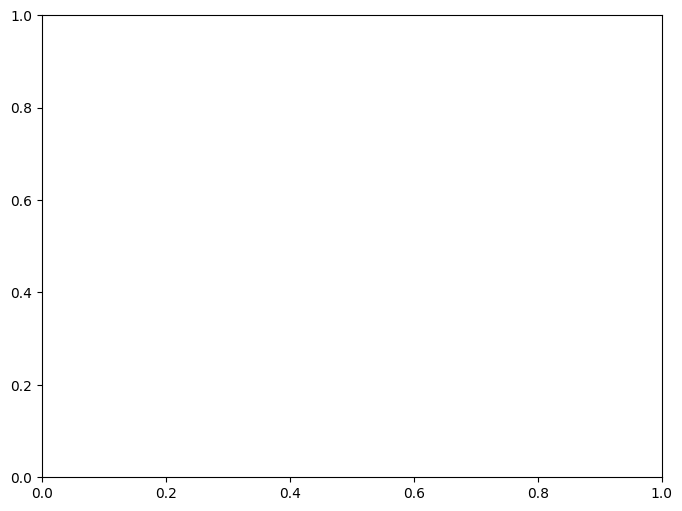

In [14]:
# Plotting Training and Validation Losses
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plotting R² Scores for Regression Parameters
for key in ['num_objects', 'energies', 'gammas']:
    plt.figure(figsize=(8,6))
    plt.plot(range(1, num_epochs+1), train_r2_scores_history[key], label=f'Training R² {key}')
    plt.plot(range(1, num_epochs+1), val_r2_scores_history[key], label=f'Validation R² {key}')
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.ylim(0,1)
    plt.title(f'Training and Validation R² Score for {key.capitalize()} Over Epochs')
    plt.legend()
    plt.show()

# Plotting Classification Accuracy for l
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_l_accuracy_history, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_l_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Training and Validation Accuracy for l Over Epochs')
plt.legend()
plt.show()


In [ ]:
# plt.hist(train_targets['gammas'].numpy().flatten(), bins=50, alpha=0.5, label='Train')
# plt.hist(val_targets['gammas'].numpy().flatten(), bins=50, alpha=0.5, label='Validation')
# plt.xlabel('Gamma Values')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()
